# Visualize the camera and gelsight poses in the dataset
Given the tracking data and calibration results, we project the camera and the gelsight sensor in the world coordinate frame, together with the object

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pytorch3d.transforms as transformations
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.utils import *
import os.path as osp
import random
from datetime import datetime

In [2]:
from utils.camera_pose_visualizer import CameraPoseVisualizer

## Set data directory

In [3]:
# set the project directory and object dataset directory
parent_dir = os.path.dirname(os.getcwd())
obj_name = "dumbbell_20231207_obj_frame"
obj_dir = osp.join(parent_dir, 'data', obj_name)
print(f"parent_dir: {parent_dir} \nobj_dir: {obj_dir}")

parent_dir: /data/ruihan/projects/NeRF-Texture 
obj_dir: /data/ruihan/projects/NeRF-Texture/data/dumbbell_20231207_obj_frame


### Visualize poses in images.txt  (Before generating .json file)

In [7]:
def visualize_cam_gelsight_poses_3D(T_camerainworld, T_gelsightinworld=None, plt_title="Visualize cameras in world frame", save_plot=False, show_plot=True, save_path=None, dpi=600, flip_transform=np.eye(4), focal_len_scaled=0.1, draw_idx=False, selected_idx=None):
    """
    """
    # Create 3D plot for visualization
    axis_margin = 0.01
    
    if len(T_camerainworld.shape) == 2:
        T_camerainworld = np.expand_dims(T_camerainworld, axis=0)
    T_camerainworld = T_camerainworld @ flip_transform
    print(f"Visualize {len(T_camerainworld)} camera poses in world frame")
    
    if T_gelsightinworld is not None:
        if len(T_gelsightinworld.shape) == 2:
            T_gelsightinworld = np.expand_dims(T_gelsightinworld, axis=0)
        T_gelsightinworld = T_gelsightinworld @ flip_transform
        print(f"Visualize {len(T_gelsightinworld)} gelsight poses in world frame")
    

    # obtain the min and max of all camera poses
    x_min = np.min(T_camerainworld[:, 0, 3]) - axis_margin
    x_max = np.max(T_camerainworld[:, 0, 3]) + axis_margin
    y_min = np.min(T_camerainworld[:, 1, 3]) - axis_margin
    y_max = np.max(T_camerainworld[:, 1, 3]) + axis_margin
    z_min = np.min(T_camerainworld[:, 2, 3]) - axis_margin
    z_max = np.max(T_camerainworld[:, 2, 3]) + axis_margin
    print(f"limit for all camera poses: x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}, z_min: {z_min}, z_max: {z_max}")

    visualizer = CameraPoseVisualizer([x_min, x_max], [y_min, y_max], [z_min, z_max])
    set_axes_equal(visualizer.ax)

    # Add camera poses in the world
    cam_colormap = plt.get_cmap("autumn")
    num_colors = len(T_camerainworld)
    colors = [cam_colormap(i / num_colors) for i in range(num_colors)]
    # Add camera poses in the world
    for i, color in zip(range(len(T_camerainworld)), colors):
        if selected_idx is not None and i not in selected_idx:
            continue
        visualizer.extrinsic2pyramid(T_camerainworld[i], color, focal_len_scaled=focal_len_scaled, idx=i, draw_idx=draw_idx)
    
    # Add gelsight poses in the world
    gelsight_colormap = plt.get_cmap("winter")
    num_colors = len(T_gelsightinworld)
    colors = [gelsight_colormap(i / num_colors) for i in range(num_colors)]
    # Add camera poses in the world
    for i, color in zip(range(len(T_gelsightinworld)), colors):
        visualizer.extrinsic2pyramid(T_gelsightinworld[i], color, focal_len_scaled=focal_len_scaled/2, idx=i)
    
    
    visualizer.show(plt_title=plt_title, save_plot=save_plot, show_plot=show_plot, save_path=save_path, dpi=dpi)

Visualize 199 camera poses in world frame
Visualize 15 gelsight poses in world frame
limit for all camera poses: x_min: -0.5401832330173467, x_max: 0.6363130671421515, y_min: -0.640085588192496, y_max: 0.6715027715424722, z_min: -0.04330662673992913, z_max: 0.45196853954078586
initialize camera pose visualizer


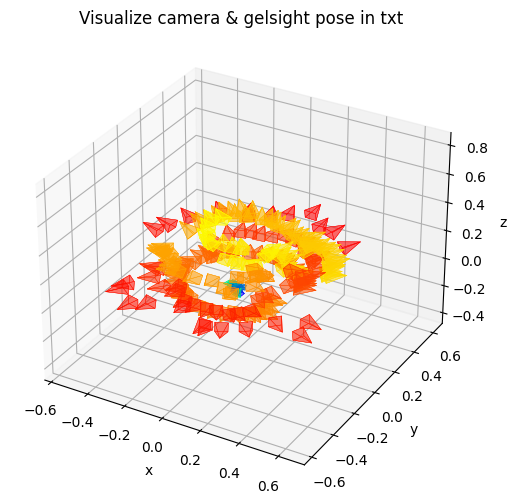

In [9]:
# Read images.txt and extract the camera poses
T_camerainworld = []
images_txt_path = osp.join(obj_dir, 'images_all.txt')
with open(images_txt_path) as f:
    images_txt = f.readlines()
    images_txt = [x.strip() for x in images_txt]
    for i in range(len(images_txt)):
        if images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, img_name = images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldincamera = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        cam_pose = np.linalg.inv(T_worldincamera)
        T_camerainworld.append(cam_pose)
T_camerainworld = np.array(T_camerainworld)


T_gelsightinworld = []
gelsight_images_txt_path = osp.join(obj_dir, 'gelsight_images_all.txt')
with open(gelsight_images_txt_path) as f:
    gelsight_images_txt = f.readlines()
    gelsight_images_txt = [x.strip() for x in gelsight_images_txt]
    for i in range(len(gelsight_images_txt)):
        if gelsight_images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, npz_name = gelsight_images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldingelsight = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        gelsight_pose = np.linalg.inv(T_worldingelsight)
        T_gelsightinworld.append(gelsight_pose)
T_gelsightinworld = np.array(T_gelsightinworld)

visualize_cam_gelsight_poses_3D(T_camerainworld, T_gelsightinworld=T_gelsightinworld, plt_title="Visualize camera & gelsight pose in txt", save_plot=True, show_plot=True, save_path=f"logs/visualize_cam_gelsight_poses_txt_{obj_name}.png", focal_len_scaled=0.1)

In [6]:
raise ValueError("Stop here")

ValueError: Stop here